In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle
import cvxpy as cvx
from scipy.special import softmax, expit, logsumexp

#### Load deep ensemble

Ensemble dimensions:

In [2]:
# Number of models in ensemble
M = 5
# Number of hidden layers
L = 2

Load NN weights:

In [3]:
w = []
b = []

# Iterate over models
for m in range(M):
    W = np.load(f'networks/mnist-{m}.npz')

    # Put weights into list of arrays
    w.append([None] * (L + 1))
    b.append([None] * (L + 1))
    for ll in range(L + 1):
        w[m][ll] = W['w' + str(ll + 1)]
        b[m][ll] = W['b' + str(ll + 1)]

#w0 = W["w1"]
#b0 = W["b1"]
#w1 = W["w2"]
#b1 = W["b2"]
#w2 = W["w3"]
#b2 = W["b3"]

In [4]:
for m in range(M):
    print(len(w[m]))
    print([ww.shape for ww in w[m]])

3
[(784, 10), (10, 10), (10, 10)]
3
[(784, 10), (10, 10), (10, 10)]
3
[(784, 10), (10, 10), (10, 10)]
3
[(784, 10), (10, 10), (10, 10)]
3
[(784, 10), (10, 10), (10, 10)]


In [5]:
print(w[0][1][0])
print(w[1][1][0])

[-0.19310552 -0.51251215  0.9495989  -0.48518208  0.59092283  0.48008457
 -0.4106386  -0.5927815  -0.40036282 -0.09690651]
[ 0.18979953 -0.8046665  -0.8333547   0.17742807 -0.03725496  0.95592374
  0.43385687 -0.4073077   0.4657115   0.6474797 ]


#### Load MNIST test images and bounds:

In [6]:
(X, y), (Xt, yt) = mnist.load_data()

Image index:

In [7]:
i = 0

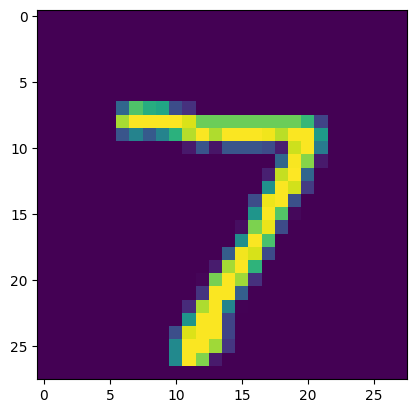

In [8]:
plt.imshow(Xt[i])
plt.show()

Perturbation radius:

In [9]:
eps = 0.008

Load neuron bounds:

In [10]:
lbs = []
ubs = []

# Iterate over models
for m in range(M):
    with open(f"./bounds/bounds_net{m}_ind{i}_eps{eps}.pickle", 'rb') as fp:
        bounds = pickle.load(fp)
    lbs.append(bounds["lbs"])
    ubs.append(bounds["ubs"])

In [11]:
lbs[1][5]

[-1.6432,
 -11.0004,
 2.2643,
 1.6698,
 -6.7737,
 -7.8203,
 -13.2744,
 10.9614,
 0.6247,
 2.4305]

#### Input layer

In [12]:
mid0 = Xt[i].flatten() / 255

In [13]:
# Input bounds
l0 = np.maximum(mid0 - eps, 0)
u0 = np.minimum(mid0 + eps, 1)

In [14]:
# Check that just computed bounds are close to loaded ones
np.abs(u0 - np.array(ubs[3][0])).max()

4.901960784314818e-05

In [15]:
D = len(mid0)
x0 = cvx.Variable(D)

In [16]:
# Initialize list of constraints
cons = [x0 >= l0, x0 <= u0]
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,)))]

#### Hidden layers

In [17]:
# Initialize lists of quantities over models
z = [None] * M
xa = [None] * M
xu = [None] * M
l = [None] * M
u = [None] * M
inactive = [None] * M
active = [None] * M
unstable = [None] * M

In [18]:
# Iterate over models
for m in range(M):
    # Initialize lists over layers
    z[m] = [None] * (L + 1)
    xa[m] = [None] * L
    xu[m] = [None] * L
    l[m] = [None] * (L + 1)
    u[m] = [None] * (L + 1)
    inactive[m] = [None] * L
    active[m] = [None] * L
    unstable[m] = [None] * L
    
    # Iterate over hidden layers
    for ll in range(L):
        # Bounds on pre-activation neurons
        # NEEDS TO BE MADE MODEL-SPECIFIC FOR DEEP ENSEMBLE
        l[m][ll] = np.array(lbs[m][2*ll+1])
        u[m][ll] = np.array(ubs[m][2*ll+1])
        #print(l[m][ll], u[m][ll])

        # Drop inactive neurons
        inactive[m][ll] = u[m][ll] <= 0
        w[m][ll] = w[m][ll][:, ~inactive[m][ll]]
        b[m][ll] = b[m][ll][~inactive[m][ll]]
        l[m][ll] = l[m][ll][~inactive[m][ll]]
        u[m][ll] = u[m][ll][~inactive[m][ll]]
        w[m][ll+1] = w[m][ll+1][~inactive[m][ll], :]
        #print(w[m][ll].shape, b[m][ll].shape, w[m][ll+1].shape)
        #print(l[m][ll], u[m][ll])

        # Find unstable and active neurons
        unstable[m][ll] = l[m][ll] < 0
        active[m][ll] = ~unstable[m][ll]
        #print(active[m][ll], unstable[m][ll])

        # Affine transformation
        if ll == 0:
            # Input layer
            z[m][ll] = x0 @ w[m][ll] + b[m][ll]
        else:
            z[m][ll] = xa[m][ll-1] @ w[m][ll][active[m][ll-1], :] + xu[m][ll-1] @ w[m][ll][unstable[m][ll-1], :] + b[m][ll]
        
        # Define active neurons
        #xa[ll] = xa[ll-1] @ w[ll-1][np.ix_(active[ll-1], active[ll])] + xu[ll-1] @ w[ll-1][np.ix_(unstable[ll-1], active[ll])] + b[ll-1][active[ll]]
        xa[m][ll] = z[m][ll][active[m][ll]]

        # Define and constrain unstable neurons
        nUnstable = unstable[m][ll].sum()
        if nUnstable:
            xu[m][ll] = cvx.Variable(nUnstable, nonneg=True)
            #cons.append( xu[ll] >= xa[ll-1] @ w[ll-1][np.ix_(active[ll-1], unstable[ll])] + xu[ll-1] @ w[ll-1][np.ix_(unstable[ll-1], unstable[ll])] + b[ll-1][unstable[ll]] )
            cons.append(xu[m][ll] >= z[m][ll][unstable[m][ll]])
            g = u[m][ll][unstable[m][ll]] / (u[m][ll][unstable[m][ll]] - l[m][ll][unstable[m][ll]])
            #cons.append( xu[ll] <= cvx.multiply(g, xa[ll-1] @ w[ll-1][np.ix_(active[ll-1], unstable[ll])] + xu[ll-1] @ w[ll-1][np.ix_(unstable[ll-1], unstable[ll])] + b[ll-1][unstable[ll]] - l[ll][unstable[ll]]) )
            cons.append(xu[m][ll] <= cvx.multiply(g, z[m][ll][unstable[m][ll]] - l[m][ll][unstable[m][ll]]))
        else:
            # No unstable neurons
            xu[m][ll] = np.zeros(nUnstable)

cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (2,))),
 Inequality(Variable((2,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True))]

In [19]:
xa, xu

([[Expression(AFFINE, UNKNOWN, (7,)), Expression(AFFINE, UNKNOWN, (8,))],
  [Expression(AFFINE, UNKNOWN, (6,)), Expression(AFFINE, UNKNOWN, (6,))],
  [Expression(AFFINE, UNKNOWN, (7,)), Expression(AFFINE, UNKNOWN, (8,))],
  [Expression(AFFINE, UNKNOWN, (7,)), Expression(AFFINE, UNKNOWN, (6,))],
  [Expression(AFFINE, UNKNOWN, (8,)), Expression(AFFINE, UNKNOWN, (8,))]],
 [[Variable((1,), nonneg=True), Variable((1,), nonneg=True)],
  [Variable((1,), nonneg=True), Variable((1,), nonneg=True)],
  [Variable((2,), nonneg=True), Variable((1,), nonneg=True)],
  [Variable((1,), nonneg=True), Variable((1,), nonneg=True)],
  [array([], dtype=float64), array([], dtype=float64)]])

In [20]:
print(lbs[4][3])
print(ubs[4][3])

[2.1145, 2.7422, 3.8015, 7.7546, 4.8569, 1.0791, 2.1942, 1.5316, -6.5672, -7.4727]
[3.6519, 4.1378, 5.117, 9.1576, 6.1207, 2.3197, 3.2161, 2.7412, -5.0606, -6.4262]


#### Logits

In [21]:
# Iterate over models
for m in range(M):
    z[m][L] = xa[m][L-1] @ w[m][L][active[m][L-1], :] + xu[m][L-1] @ w[m][L][unstable[m][L-1], :] + b[m][L]
z

[[Expression(AFFINE, UNKNOWN, (8,)),
  Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (10,))],
 [Expression(AFFINE, UNKNOWN, (7,)),
  Expression(AFFINE, UNKNOWN, (7,)),
  Expression(AFFINE, UNKNOWN, (10,))],
 [Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (10,))],
 [Expression(AFFINE, UNKNOWN, (8,)),
  Expression(AFFINE, UNKNOWN, (7,)),
  Expression(AFFINE, UNKNOWN, (10,))],
 [Expression(AFFINE, UNKNOWN, (8,)),
  Expression(AFFINE, UNKNOWN, (8,)),
  Expression(AFFINE, UNKNOWN, (10,))]]

In [22]:
# Bounds on logits
# NEEDS TO BE MODEL-SPECIFIC FOR DEEP ENSEMBLE
for m in range(M):
    l[m][L] = np.array(lbs[m][2*L+1])
    u[m][L] = np.array(ubs[m][2*L+1])
#l2 = np.array(lbs[5])
#u2 = np.array(ubs[5])
#l, u

In [23]:
# Index of largest logit in terms of midpoint
jmax = np.empty(M, dtype=int)
for m in range(M):
    jmax[m] = (l[m][L] + u[m][L]).argmax()
jmax

array([7, 7, 7, 7, 7])

#### Softmax

In [24]:
LBtype = 'lin'
UBtype = 'lin'

In [25]:
# Number of classes
d = 10

# Output probabilities
p = cvx.Variable((M, d), nonneg=True)

Load and compute bounds:

In [26]:
# Bounds on logit differences
diffs_l = np.empty((M, d, d-1))
diffs_u = np.empty((M, d, d-1))
# Bounds on probabilities
sm_l = np.empty((M, d))
sm_u = np.empty((M, d))
if UBtype == 'LSE':
    lsm_l = np.empty((M, d))
    lsm_u = np.empty((M, d))

# Iterate over models
for m in range(M):
    # Iterate over classes
    for j in range(d):
        # Bounds on logit differences z_{j'} - z_j
        # NEEDS TO BE MODEL-SPECIFIC FOR DEEP ENSEMBLE 
        diffs_l[m, j] = np.array(lbs[m][2*(L+1)])[(d-1)*j:(d-1)*(j+1)]
        diffs_u[m, j] = np.array(ubs[m][2*(L+1)])[(d-1)*j:(d-1)*(j+1)]
        # Constant bounds on softmax output
        sm_l[m, j] = expit(-logsumexp(diffs_u[m, j]))
        sm_u[m, j] = expit(-logsumexp(diffs_l[m, j]))
        if UBtype == 'LSE':
            # Also need log of constant bounds
            lsm_l[m, j], lsm_u[m, j] = np.log(sm_l[m, j]), np.log(sm_u[m, j])


In [27]:
print(sm_l)
print(sm_u)

[[8.16242010e-06 4.09312976e-08 5.00955898e-04 2.66599216e-03
  6.41386515e-07 2.87680890e-06 1.70034911e-12 9.54664722e-01
  6.06122309e-08 7.66593859e-06]
 [1.28587098e-06 9.32036535e-11 7.16617564e-05 3.48515801e-05
  7.42595491e-09 2.52095639e-09 9.93733512e-12 9.98421774e-01
  1.16029140e-05 7.92729756e-05]
 [5.18144164e-07 1.14301673e-09 8.34347169e-07 1.07878661e-03
  3.90653548e-11 5.80205821e-08 9.63253671e-16 9.59471495e-01
  2.81942386e-07 6.55692794e-05]
 [1.18417203e-07 6.04071829e-08 5.79549200e-05 3.63520856e-04
  5.82903709e-11 1.04892497e-06 1.41905640e-12 9.91698505e-01
  1.63241396e-06 1.42439136e-04]
 [5.45593015e-07 2.09276063e-06 3.64802286e-05 9.04262482e-06
  6.94061293e-06 4.66725316e-06 1.43164478e-06 9.97989669e-01
  2.19349210e-07 5.61995621e-06]]
[[2.94950674e-04 1.08400227e-06 3.93832291e-03 3.99740779e-02
  2.78032590e-05 2.52094435e-04 2.29795660e-10 9.96807482e-01
  1.59987217e-05 1.13173551e-03]
 [9.91120562e-06 1.60635859e-09 8.30354818e-04 3.04862182

Constrain softmax outputs:

In [28]:
# Iterate over models
diffs = [None] * M
for m in range(M):
    # Iterate over classes
    for j in range(d):

        if LBtype == 'lin' or UBtype == 'lin':
            # Pre-compute some quantities for linear bounds
            # Tangent points for bounding exponentials from below
            diffs_t = np.minimum(np.log((np.exp(diffs_u[m, j]) - np.exp(diffs_l[m, j])) / (diffs_u[m, j] - diffs_l[m, j])), diffs_l[m, j] + 1)
            # Lower and upper bounds on denominator of softmax
            den_l = 1 + np.dot(np.exp(diffs_t), diffs_l[m, j] - diffs_t + 1)
            den_u = 1 + np.exp(diffs_u[m, j]).sum()
            # Tangent point for bounding reciprocal from below
            den_t = max(np.sqrt(den_l * den_u), den_u / 2)
            
        # Add constraint on jth softmax output
        if j == yt[i]:
            # Correct class, need lower bound on probability
            if LBtype == 'lin':
                # Linear ER bound
                a_lin_l = np.zeros(d)
                others = np.arange(d) != j
                a_lin_l[others] = -(np.exp(diffs_u[m, j]) - np.exp(diffs_l[m, j])) / (diffs_u[m, j] - diffs_l[m, j]) / den_t**2
                a_lin_l[j] = -a_lin_l[others].sum()
                b_lin_l = ((diffs_u[m, j] * np.exp(diffs_l[m, j]) - diffs_l[m, j] * np.exp(diffs_u[m, j])) / (diffs_u[m, j] - diffs_l[m, j])).sum()
                b_lin_l = 1 / den_t * (2 - 1 / den_t * (1 + b_lin_l))
                bnd = p[m, j] >= a_lin_l @ z[m][L] + b_lin_l
            elif LBtype == 'ER' or j == jmax[m]:
                # LSE2 bound same as ER bound when j = jmax
                # Differences with z_j
                others = np.arange(d) != j
                diffs[m] = z[m][L][others] - z[m][L][j]
                #cons += [diffs[j] >= diffs_l[j], diffs[j] <= diffs_u[j]]
                #bnd = p[j] >= cvx.power(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[j]), diffs_u[j] - diffs[j]) + cvx.multiply(np.exp(diffs_u[j]), diffs[j] - diffs_l[j])) / (diffs_u[j] - diffs_l[j])), -1)
                # Bounding log probability avoids having to use a second-order cone
                bnd = cvx.log(p[m, j]) >= -cvx.log(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[m, j]), diffs_u[m, j] - diffs[m]) + cvx.multiply(np.exp(diffs_u[m, j]), diffs[m] - diffs_l[m, j])) / (diffs_u[m, j] - diffs_l[m, j])))
            elif LBtype == 'LSE':
                # LSE2 bound for j != jmax
                # Differences with z_{jmax}
                others = np.arange(d) != jmax[m]
                diffs[m] = z[m][L] - z[m][L][jmax[m]]
                bnd = cvx.log(p[m, j]) >= diffs[m][j] - cvx.log(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[m, jmax[m]]), diffs_u[m, jmax[m]] - diffs[m][others]) + cvx.multiply(np.exp(diffs_u[m, jmax[m]]), diffs[m][others] - diffs_l[m, jmax[m]])) / (diffs_u[m, jmax[m]] - diffs_l[m, jmax[m]])))
            if LBtype == 'LSE':
                # LSE1 bound
                bnd2 = cvx.log(p[m, j]) >= z[m][L][j] - cvx.log(cvx.sum((cvx.multiply(np.exp(l[m][L]), u[m][L] - z[m][L]) + cvx.multiply(np.exp(u[m][L]), z[m][L] - l[m][L])) / (u[m][L] - l[m][L])))
                #cons.append(bnd2)
        else:
            # Incorrect class, need upper bound on probability
            if UBtype == 'lin':
                # Linear ER bound
                a_lin_u = np.zeros(d)
                others = np.arange(d) != j
                a_lin_u[others] = -np.exp(diffs_t) / (den_l * den_u)
                a_lin_u[j] = -a_lin_u[others].sum()
                b_lin_u = 1 / den_l + 1 / den_u - (1 + np.dot(np.exp(diffs_t), 1 - diffs_t)) / (den_l * den_u)
                bnd = p[m, j] <= a_lin_u @ z[m][L] + b_lin_u
            elif UBtype == 'ER':
                # CAN'T USE: HAVING MORE THAN 2 OF THESE BOUNDS PREVENTS CONVERGENCE 
                #bnd = p[j] <= sm_l[j] + sm_u[j] - sm_l[j] * sm_u[j] * (1 + cvx.sum(cvx.exp(diffs[j])))
                bnd = p[m, j] <= sm_l[m, j] + sm_u[m, j] - sm_l[m, j] * sm_u[m, j] * cvx.exp(cvx.log_sum_exp(z[m][L]) - z[m][L][j])
            elif UBtype == 'LSE':
                bnd = p[m, j] <= (lsm_u[m, j] * sm_l[m, j] - lsm_l[m, j] * sm_u[m, j] - (sm_u[m, j] - sm_l[m, j]) * (cvx.log_sum_exp(z[m][L]) - z[m][L][j])) / (lsm_u[m, j] - lsm_l[m, j])
        cons.append(bnd)

    # Sum to 1 constraint
    cons.append(cvx.sum(p[m, :]) == 1)

In [29]:
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (2,))),
 Inequality(Variable((2,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (1,))),
 Inequality(Variable((1,), nonneg=True)),
 Inequality(Expression(AFFINE, NONNEGATIVE, ())),
 Inequality(Expression(AFFINE, NONNEGATIVE, ())),
 Inequality(Expression(AFFINE, NONNEGATIVE, ())),
 Inequality(Expression(AFFINE, NONNEGATIVE, (

#### Score function upper bound (use only one of the following)

Negative log-likelihood: equivalently minimize probability of correct class

In [30]:
#score_ub = -p[yt[i]]
score_ub = -cvx.sum(p[:, yt[i]]) / M

Brier score: linear upper bound

In [49]:
others = np.arange(d) != yt[i]
score_ub = -(2 - sm_l[:, yt[i]].mean() - sm_u[:, yt[i]].mean()) * cvx.sum(p[:, yt[i]]) / M + (sm_l[:, others].mean(axis=0) + sm_u[:, others].mean(axis=0)) @ cvx.sum(p[:, others], axis=0) / M - np.dot(sm_l.mean(axis=0), sm_u.mean(axis=0)) + 1 

In [50]:
score_ub

Expression(AFFINE, UNKNOWN, ())

#### Solve problem

In [51]:
prob = cvx.Problem(cvx.Maximize(score_ub), cons)

In [52]:
prob.solve(solver='SCS', verbose=True, acceleration_lookback=0, max_iters=int(1e4))
#prob.solve(solver='SCS', verbose=True, acceleration_lookback=0, max_iters=int(1e4), eps=1e-5)
#prob.solve(solver='SCS', verbose=True, acceleration_lookback=0, max_iters=int(1e4), scale=0.01)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 55157
eps = 1.00e-04, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
acceleration_lookback = 0, rho_x = 1.00e-03
Variables n = 843, constraints m = 1700
Cones:	primal zero / dual free vars: 5
	linear vars: 1695
Setup time: 1.06e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.18e+00  8.53e-02  2.51e-01 -3.31e-01  4.74e-03  8.02e-17  2.73e-03 
   100| 2.69e-03  1.42e-04  1.76e-04  1.99e-02  1.97e-02  2.14e-18  2.07e-02 
   200| 6.58e-04  4.72e-05  4.94e-05  1.99e-02  1.99e-02  7.95e-18  3.80e-02 
   300| 2.1

0.0006721039696381201

In [53]:
prob.value

0.0006721039696381201

In [54]:
prob.status

'optimal'

Check values of variables:

In [55]:
for m in range(2):
    print(np.hstack((l[m][L][:,np.newaxis], z[m][L].value[:,np.newaxis], u[m][L][:,np.newaxis])))

[[  1.8117       2.72938061   3.7385    ]
 [ -3.6509      -2.89044055  -1.9574    ]
 [  4.7991       5.75015442   7.2427    ]
 [  7.2054       8.2013068    8.9914    ]
 [ -0.75         0.17778978   1.3051    ]
 [  1.283        2.8058071    2.9718    ]
 [-13.0397     -11.46452456 -10.963     ]
 [ 11.0574      11.50672687  14.1932    ]
 [ -2.5334      -0.44001715   0.2762    ]
 [  2.0738       3.39627875   4.6493    ]]
[[ -1.6432      -0.70844717  -0.1942    ]
 [-11.0004     -10.09857254  -9.0746    ]
 [  2.2643       3.27576939   4.365     ]
 [  1.6698       2.52755622   3.2216    ]
 [ -6.7737      -6.27380527  -5.5967    ]
 [ -7.8203      -6.27638085  -5.285     ]
 [-13.2744     -12.09508335 -11.2941    ]
 [ 10.9614      11.27100572  12.303     ]
 [  0.6247       1.78679536   2.1705    ]
 [  2.4305       2.80496033   3.3569    ]]


In [37]:
for m in range(2):
    print(np.hstack((diffs_l[m,yt[0],np.newaxis].T, diffs[m].value[:,np.newaxis], diffs_u[m,yt[0],np.newaxis].T)))

AttributeError: 'NoneType' object has no attribute 'value'

In [56]:
for m in range(2):
    print(np.hstack((sm_l[m,np.newaxis].T, softmax(z[m][L].value)[:,np.newaxis], p.value[m,np.newaxis].T, sm_u[m,np.newaxis].T)))
#np.hstack((sm_l[:,np.newaxis], p.value[:,np.newaxis], softmax(z.value)[:,np.newaxis], sm_u[:,np.newaxis])) 

[[8.16242010e-06 1.48187236e-04 0.00000000e+00 2.94950674e-04]
 [4.09312976e-08 5.37221617e-07 0.00000000e+00 1.08400227e-06]
 [5.00955898e-04 3.03889849e-03 0.00000000e+00 3.93832291e-03]
 [2.66599216e-03 3.52564149e-02 4.39379031e-02 3.99740779e-02]
 [6.41386515e-07 1.15523138e-05 0.00000000e+00 2.78032590e-05]
 [2.87680890e-06 1.59956687e-04 0.00000000e+00 2.52094435e-04]
 [1.70034911e-12 1.01502352e-10 0.00000000e+00 2.29795660e-10]
 [9.54664722e-01 9.61089529e-01 9.56550423e-01 9.96807482e-01]
 [6.06122309e-08 6.22814677e-06 0.00000000e+00 1.59987217e-05]
 [7.66593859e-06 2.88696143e-04 0.00000000e+00 1.13173551e-03]]
[[1.28587098e-06 6.26681693e-06 0.00000000e+00 9.91120562e-06]
 [9.32036535e-11 5.23561102e-10 0.00000000e+00 1.60635859e-09]
 [7.16617564e-05 3.36798596e-04 0.00000000e+00 8.30354818e-04]
 [3.48515801e-05 1.59376917e-04 6.98974965e-04 3.04862182e-04]
 [7.42595491e-09 2.39906875e-08 4.09905492e-04 4.44212988e-08]
 [2.52095639e-09 2.39289771e-08 0.00000000e+00 6.44741

Checks for NLL:

In [57]:
def eval_ER_l(X, diffs_l, diffs_u):
    """
    Evaluate exponential-reciprocal lower bound at points in X (shape (n, d))
    """
    diffs = X[:, np.arange(d)!=yt[i]] - X[:, yt[i]]
    # Coefficients of affine function of diffs
    a_ER_l = (np.exp(diffs_u) - np.exp(diffs_l)) / (diffs_u - diffs_l)
    b_ER_l = ((diffs_u * np.exp(diffs_l) - diffs_l * np.exp(diffs_u)) / (diffs_u - diffs_l)).sum()
    
    ER_l = 1 / (1 + np.dot(diffs, a_ER_l) + b_ER_l)
    return ER_l


In [58]:
pStarLB = np.empty(M)
for m in range(M):
    pStarLB[m] = eval_ER_l(z[m][L].value[np.newaxis, :], diffs_l[m,yt[i]], diffs_u[m,yt[i]])
print(pStarLB)
print(pStarLB.mean())

[0.95706412 0.99887443 0.96218544 0.99303047 0.99839486]
0.9819098635229982


In [59]:
p.value

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.39379031e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.56550423e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.98974965e-04,
        4.09905492e-04, 0.00000000e+00, 0.00000000e+00, 9.98806388e-01,
        0.00000000e+00, 2.46739434e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.84481034e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.61805972e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.35546139e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.92942288e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.91213624e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.98320098e-01,
        0.00000000e+00, 0.00000000e+00]])

Checks for Brier score:

In [60]:
logits = np.empty((M, d))
for m in range(M):
    logits[m] = z[m][L].value
softmax(logits, axis=1)

array([[1.48187236e-04, 5.37221617e-07, 3.03889849e-03, 3.52564149e-02,
        1.15523138e-05, 1.59956687e-04, 1.01502352e-10, 9.61089529e-01,
        6.22814677e-06, 2.88696143e-04],
       [6.26681693e-06, 5.23561102e-10, 3.36798596e-04, 1.59376917e-04,
        2.39906875e-08, 2.39289771e-08, 7.11039531e-11, 9.99211196e-01,
        7.59831107e-05, 2.10329648e-04],
       [7.49899028e-06, 1.40261776e-08, 1.06606816e-05, 3.12976726e-02,
        5.97865180e-10, 5.87959378e-06, 8.46225644e-14, 9.68159731e-01,
        1.00835236e-05, 5.08458535e-04],
       [3.36269860e-06, 4.11708337e-07, 4.13967153e-04, 3.66492958e-03,
        1.07364344e-09, 2.95562005e-05, 4.71705039e-11, 9.94718893e-01,
        2.81676016e-05, 1.14071063e-03],
       [4.67453164e-06, 1.53588931e-05, 5.45093807e-04, 2.12446649e-04,
        7.13315811e-05, 8.51637100e-05, 8.30072927e-06, 9.99004647e-01,
        4.12915065e-06, 4.88544129e-05]])

In [61]:
((softmax(logits, axis=1).mean(axis=0) - (np.arange(d) == yt[0]))**2).sum()

0.0004424894895340013

In [62]:
test = sm_u.copy()
test[:, yt[i]] = sm_l[:, yt[i]]
((test.mean(axis=0) - (np.arange(d) == yt[i]))**2).sum()

0.0006747775436752736

In [63]:
test.mean(axis=0)

array([6.67207634e-05, 5.74700220e-06, 1.33696517e-03, 1.70193998e-02,
       3.42051326e-05, 8.64760679e-05, 2.17573954e-06, 9.80449233e-01,
       3.99986564e-05, 1.04060985e-03])

In [64]:
-(2 - sm_l[:, yt[i]].mean() - sm_u[:, yt[i]].mean()) * p.value[:, yt[i]].mean() + (sm_l[:, others].mean(axis=0) + sm_u[:, others].mean(axis=0)) @ p.value[:, others].mean(axis=0) - np.dot(sm_l.mean(axis=0), sm_u.mean(axis=0)) + 1 

0.0006721710796561142

In [65]:
-(2 - sm_l[:, yt[i]].mean() - sm_u[:, yt[i]].mean()) * test[:,yt[i]].mean() + (sm_l[:, others].mean(axis=0) + sm_u[:, others].mean(axis=0)) @ test[:,others].mean(axis=0) - np.dot(sm_l.mean(axis=0), sm_u.mean(axis=0)) + 1 

0.0006747775436751757

## OLD

#### Hidden layer 1

In [705]:
l0 = np.array(lbs[1])
u0 = np.array(ubs[1])
l0, u0

(array([-1.2855,  0.6487,  0.5012, -3.622 , -2.8138, -0.5145,  2.1417,
         1.1181,  2.7157,  7.5092]),
 array([ 2.1951,  4.4368,  3.454 , -0.8622,  0.0459,  3.5994,  4.9922,
         4.9872,  6.7239, 10.9493]))

In [706]:
# Drop inactive neurons
inactive0 = u0 <= 0
w0 = w0[:, ~inactive0]
b0 = b0[~inactive0]
l0 = l0[~inactive0]
u0 = u0[~inactive0]

In [707]:
w1 = w1[~inactive0, :]
w1.shape

(9, 10)

In [708]:
w0.shape, b0.shape
l0, u0

(array([-1.2855,  0.6487,  0.5012, -2.8138, -0.5145,  2.1417,  1.1181,
         2.7157,  7.5092]),
 array([ 2.1951,  4.4368,  3.454 ,  0.0459,  3.5994,  4.9922,  4.9872,
         6.7239, 10.9493]))

In [709]:
unstable0 = l0 < 0
active0 = ~unstable0
active0, unstable0

(array([False,  True,  True, False, False,  True,  True,  True,  True]),
 array([ True, False, False,  True,  True, False, False, False, False]))

In [710]:
nActive = active0.sum()
nUnstable = unstable0.sum()
#xa1 = cvx.Variable(nActive)
xu1 = cvx.Variable(nUnstable, nonneg=True)

In [650]:
cons.append(xa1 == x0 @ w0[:, active0] + b0[active0])
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,)))]

In [651]:
cons += [xa1 >= l0[active0], xa1 <= u0[active0]]
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,)))]

In [711]:
xa1 = x0 @ w0[:, active0] + b0[active0]
xa1

Expression(AFFINE, UNKNOWN, (6,))

In [712]:
cons.append(xu1 >= x0 @ w0[:, unstable0] + b0[unstable0])
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,)))]

In [713]:
g0 = u0[unstable0] / (u0[unstable0] - l0[unstable0])
cons.append(xu1 <= cvx.multiply(g0, x0 @ w0[:, unstable0] + b0[unstable0] - l0[unstable0]))
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True))]

#### Hidden layer 2

In [714]:
l1 = np.array(lbs[3])
u1 = np.array(ubs[3])
l1, u1

(array([-0.3692,  1.4975, -6.9588, -1.2922,  5.5931,  2.4842, -1.4013,
         6.9371, -1.712 ,  0.181 ]),
 array([ 3.3785,  4.9457, -2.9962,  1.5076, 11.3816,  6.3993,  1.7474,
        12.2549,  1.71  ,  3.7962]))

In [715]:
# Drop inactive neurons
inactive1 = u1 <= 0
w1 = w1[:, ~inactive1]
b1 = b1[~inactive1]
l1 = l1[~inactive1]
u1 = u1[~inactive1]
w2 = w2[~inactive1, :]

In [716]:
print(w1.shape, b1.shape, w2.shape)
l1, u1

(9, 9) (9,) (9, 10)


(array([-0.3692,  1.4975, -1.2922,  5.5931,  2.4842, -1.4013,  6.9371,
        -1.712 ,  0.181 ]),
 array([ 3.3785,  4.9457,  1.5076, 11.3816,  6.3993,  1.7474, 12.2549,
         1.71  ,  3.7962]))

In [717]:
unstable1 = l1 < 0
active1 = ~unstable1
active1, unstable1

(array([False,  True, False,  True,  True, False,  True, False,  True]),
 array([ True, False,  True, False, False,  True, False,  True, False]))

In [718]:
nActive = active1.sum()
nUnstable = unstable1.sum()
#xa2 = cvx.Variable(nActive)
xu2 = cvx.Variable(nUnstable, nonneg=True)

In [659]:
# indices of active and unstable should be one greater
cons.append(xa2 == xa1 @ w1[np.ix_(active0, active1)] + xu1 @ w1[np.ix_(unstable0, active1)] + b1[active1])
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Equality(Variable((5,)), Expression(AFFINE, UNKNOWN, (5,)))]

In [660]:
cons += [xa2 >= l1[active1], xa2 <= u1[active1]]
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Equality(Variable((5,)), Expression(AFFINE, UNKNOWN, (5,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (5,))),
 Inequality(Variable((5,)))]

In [719]:
xa2 = xa1 @ w1[np.ix_(active0, active1)] + xu1 @ w1[np.ix_(unstable0, active1)] + b1[active1]
xa2

Expression(AFFINE, UNKNOWN, (5,))

In [720]:
cons.append(xu2 >= xa1 @ w1[np.ix_(active0, unstable1)] + xu1 @ w1[np.ix_(unstable0, unstable1)] + b1[unstable1])
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,)))]

In [721]:
g1 = u1[unstable1] / (u1[unstable1] - l1[unstable1])
cons.append(xu2 <= cvx.multiply(g1, xa1 @ w1[np.ix_(active0, unstable1)] + xu1 @ w1[np.ix_(unstable0, unstable1)] + b1[unstable1] - l1[unstable1]))
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True))]

#### Logits

In [663]:
z = cvx.Variable(10)

In [613]:
cons = []

In [665]:
cons += [z >= l2, z <= u2]
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Equality(Variable((5,)), Expression(AFFINE, UNKNOWN, (5,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (5,))),
 Inequality(Variable((5,))),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Constant(CONSTANT, UNKNOWN, (10,))),
 Inequality(Variable((10,)))]

In [666]:
cons.append(z == xa2 @ w2[active1, :] + xu2 @ w2[unstable1, :] + b2)
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Equality(Variable((5,)), Expression(AFFINE, UNKNOWN, (5,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (5,))),
 Inequality(Variable((5,))),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Constant(CONSTANT, UNKNOWN, (10,))),
 Inequality(Variable((10,))),
 Equality(Variable((10,)), Expression(AFFINE, UNKNOWN, (10,)))]

#### Score function upper bound

Negative log-likelihood, using LSE lower bound 1:

In [36]:
score_ub = cvx.log(cvx.sum((cvx.multiply(np.exp(l2), u2 - z) + cvx.multiply(np.exp(u2), z - l2)) / (u2 - l2))) - z[yt[0]]

#### Solve problem

In [371]:
j = yt[0]
obj = cvx.power(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[j]), diffs_u[j] - diffs[j]) + cvx.multiply(np.exp(diffs_u[j]), diffs[j] - diffs_l[j])) / (diffs_u[j] - diffs_l[j])), -1)
#obj = cvx.log(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[j]), diffs_u[j] - diffs[j]) + cvx.multiply(np.exp(diffs_u[j]), diffs[j] - diffs_l[j])) / (diffs_u[j] - diffs_l[j])))
#prob = cvx.Problem(cvx.Maximize(obj), cons)
#prob = cvx.Problem(cvx.Minimize(obj), cons)
bnds = []
for j in [0, 3, 9]:
    bnds.append(p[j] <= sm_l[j] + sm_u[j] - sm_l[j] * sm_u[j] * (1 + cvx.sum(cvx.exp(diffs[j]))) )
prob = cvx.Problem(cvx.Minimize(p[yt[0]]), cons + [p[yt[0]] >= obj, cvx.sum(p) == 1] + bnds)

## Scratch

In [85]:
sm_l + sm_u - sm_l * sm_u * (1 + np.exp(z.value[others] - z.value[yt[0]]).sum())

0.9966685287667276

In [86]:
(lsm_u * sm_l - lsm_l * sm_u - (sm_u - sm_l) * (logsumexp(z.value) - z.value[yt[0]])) / (lsm_u - lsm_l)

0.9966673006736713

In [212]:
def eval_hybrid_l(X, l, u):
    """
    Evaluate hybrid LSE-ER lower bound at points in X (shape (n, d))
    """
    # Linear upper bound on sum of exponentials
    a = (np.exp(u) - np.exp(l)) / (u - l)
    b = ((u * np.exp(l) - l * np.exp(u)) / (u - l)).sum()
    se_u = np.dot(X, a) + b
    hybrid_l = np.exp(X[:, yt[0]]) / se_u
    return hybrid_l


In [214]:
-np.log(eval_hybrid_l(z.value[np.newaxis, :], l2, u2))

array([0.58342397])

In [241]:
prob = cvx.Problem(cvx.Minimize(z[7] - z[0]), cons)

In [242]:
prob.solve(solver='SCS')

8.720675386749766

In [244]:
l2, u2

(array([ -5.1751,  -6.4589,  -3.4669,  -2.0331,  -4.7503,  -4.8355,
        -11.6982,   5.8715,  -6.908 ,  -1.0644]),
 array([-2.0966, -3.9739, -1.5482, -0.4229, -1.8881, -2.5569, -8.2361,
         8.0983, -5.2155,  0.9379]))

In [245]:
z.value

array([-2.29431912, -5.31180294, -2.39607773, -1.14592626, -3.09482053,
       -2.99467201, -9.1358624 ,  6.42635627, -5.42358417, -0.22449742])

In [247]:
a = (np.exp(u2) - np.exp(l2)) / (u2 - l2)
a

array([3.80762831e-02, 6.93499081e-03, 9.45518951e-02, 3.25559019e-01,
       4.98602537e-02, 3.05459673e-02, 7.41187851e-05, 1.31762686e+03,
       2.61858885e-03, 1.10356907e+00])

In [249]:
b = ((u2 * np.exp(l2) - l2 * np.exp(u2)) / (u2 - l2)).sum()
b

-7378.323749876522

In [251]:
se_u = np.dot(z.value, a) + b
se_u

1087.9836312842463

In [252]:
np.exp(z.value[yt[0]])

617.9183117110357

In [258]:
diffs_l = l2[np.arange(10)!=yt[0]] - u2[yt[0]]
diffs_u = u2[np.arange(10)!=yt[0]] - l2[yt[0]]
eval_ER_l(z.value[np.newaxis, :], diffs_l, diffs_u)

array([0.99328834])

In [261]:
np.array(lbs[6])[63:72]

array([-12.5444, -14.0241, -10.9431,  -9.7428, -11.891 , -12.4112,
       -19.1028, -14.6832,  -8.0356])

In [263]:
eval_ER_l(z.value[np.newaxis, :], np.array(lbs[6])[63:72], np.array(ubs[6])[63:72])

array([0.99679823])

In [273]:
diffs_l = np.array(lbs[6])[63:72]
diffs_u = np.array(ubs[6])[63:72]

In [274]:
sm_l = 1 / (1 + np.exp(diffs_u).sum())
sm_u = 1 / (1 + np.exp(diffs_l).sum())
sm_l, sm_u

(0.9958275057469839, 0.9995843211162739)

In [280]:
lsm_l = np.log(sm_l)
lsm_u = np.log(sm_u)
lsm_l, lsm_u

(-0.004181223397159428, -0.000415765302142292)

In [275]:
from scipy.special import logsumexp
lse_l = logsumexp(diffs_l)
lse_u = logsumexp(diffs_u)
lse_l, lse_u

(-7.78518174460023, -5.475060056379923)

In [276]:
diffs = z.value[np.arange(10)!=yt[0]] - z.value[yt[0]]
print(diffs_l)
print(diffs)
print(diffs_u)

[-12.5444 -14.0241 -10.9431  -9.7428 -11.891  -12.4112 -19.1028 -14.6832
  -8.0356]
[ -8.72067539 -11.73815921  -8.82243399  -7.57228252  -9.5211768
  -9.42102828 -15.56221867 -11.84994043  -6.65085369]
[ -8.7134 -10.4332  -8.1062  -6.7326  -8.7978  -8.9615 -14.8448 -11.3933
  -6.1138]


In [272]:
logsumexp(diffs)

-6.080259301010307

In [277]:
a = (np.exp(diffs_u) - np.exp(diffs_l)) / (diffs_u - diffs_l)
b = ((diffs_u * np.exp(diffs_l) - diffs_l * np.exp(diffs_u)) / (diffs_u - diffs_l)).sum()
np.log(np.dot(diffs, a) + b)

-5.740845292030437

In [281]:
np.exp((lse_u * lsm_u - lse_l * lsm_l - (lsm_u - lsm_l) * np.log(np.dot(diffs, a) + b)) / (lse_u - lse_l))

0.996259016883389

In [282]:
1 / (1 + np.dot(diffs, a) + b)

0.9967982322390713

In [284]:
np.log(1 + np.exp(logsumexp(diffs)))

0.002284970867912273

In [285]:
np.log(1 + np.dot(diffs, a) + b)

0.003206904386444612

In [286]:
(lse_u * lsm_u - lse_l * lsm_l - (lsm_u - lsm_l) * np.log(np.dot(diffs, a) + b)) / (lse_u - lse_l)

-0.0037479980946918

In [287]:
np.exp(logsumexp(diffs))

0.00228758340332274

In [288]:
np.dot(diffs, a) + b

0.0032120520054864012